In [20]:
import torch
import numpy as np
import pandas as pd
from dataloader import DerpData
from torch.utils.data import DataLoader
from net.regressor import Regressor
import matplotlib.pyplot as plt
import os
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
checkpoint_path = os.path.join('checkpoint', 'regressor_30.000000_0.001000.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device=='cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [33]:
test_data = DerpData(X_filepath='X.csv', y_filepath='y.csv', is_train=False)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)
model = Regressor(input_dim=test_data.X_dim, output_dim=test_data.y_dim).to(device)
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

Regressor(
  (relu): ReLU()
  (bn_1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_4): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=12, out_features=100, bias=True)
  (fc_2): Linear(in_features=100, out_features=200, bias=True)
  (fc_3): Linear(in_features=200, out_features=400, bias=True)
  (fc_4): Linear(in_features=400, out_features=9, bias=True)
)

In [34]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [35]:
def loss_function(output, label, binary_label, label_mask, binary_label_mask, scale_bce, test=False):
    # Regression
    reg_loss = torch.nn.SmoothL1Loss(reduction='none')(output[:, :-1], label)
    reg_loss[label_mask] = 0.0
    reduced_reg_loss = torch.mean(torch.sum(reg_loss, dim=1))
    
    # Binary classification
    bce_output = output[:, -1].reshape(-1, 1) # Take last dim for classification
    if test:
        pos_weight = None
    else:
        num_negatives = torch.sum(binary_label == 0.0, dim=0).float()
        num_positives = torch.sum(binary_label == 1.0, dim=0).float()
        #print(num_negatives, num_positives)
        pos_weight = num_negatives/(num_positives) # 1 to prevent zero division
    #print(pos_weight)
    bce_loss = torch.nn.BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight)(bce_output, binary_label)
    bce_loss[binary_label_mask] = 0.0
    reduced_bce_loss = torch.mean(bce_loss)
    
    return reduced_reg_loss + reduced_bce_loss*scale_bce

In [36]:
test_loss = 0
output_to_save = None
with torch.no_grad():
    for i, (testbatch_X, testbatch_y, testbatch_bin_y, testmask_X, testmask_y, testmask_bin_y) in enumerate(test_loader):
        testbatch_X = testbatch_X.float().to(device)
        testbatch_y = testbatch_y.float().to(device)
        testbatch_bin_y = testbatch_bin_y.float().to(device)
        output = model(testbatch_X)
        if output_to_save is not None:
            output_to_save = np.concatenate([output_to_save, output.detach().cpu().numpy()], axis=0)
        else:
            output_to_save = output.detach().cpu().numpy()
        test_loss += loss_function(output, testbatch_y, testbatch_bin_y, testmask_y, testmask_bin_y, scale_bce=0.1, test=True).item()
test_loss = test_loss/len(test_loader.dataset)
print("Final test loss: ", test_loss)

Final test loss:  0.0018679394430559596


In [37]:
np.save('test_X', test_data.X)
test_y_combined = np.concatenate([test_data.y, test_data.y_binary], axis=1)
np.save('test_y', test_y_combined)
np.save('test_output', output_to_save)

In [38]:
column_ordering = test_data.y_columns
test_output = pd.DataFrame(output_to_save, columns=column_ordering)
test_labels = pd.DataFrame(test_y_combined, columns=column_ordering)

Text(0.5,1,'extendedness')

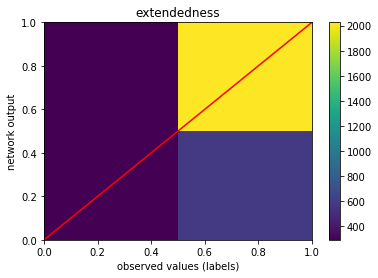

In [40]:
#column = 'mag_r_cModel'
#column = 'r_modelfit_CModel_flux'
column = 'extendedness'
#column = 'ra'

x = test_labels[column]

if column == 'extendedness':
    y = test_output[column]
    y = sigmoid(y)
    y = (y > 0.5).astype(np.float32)
    bins = 2
else:
    y = test_output[column]
    bins = 30
#print(np.min(x), np.max(x))
line_x = np.linspace(np.min(x), np.max(x))
line_y = line_x
plt.plot(line_x, line_y, color='r')
hist = plt.hist2d(x, y, bins=bins, range=[[np.min(x), np.max(x)], [np.min(y), np.max(y)]], normed=False)
plt.colorbar()
plt.xlabel("observed values (labels)")
plt.ylabel("network output")
plt.title(column)

In [41]:
hist

(array([[ 296.,  294.],
        [ 591., 2026.]]),
 array([0. , 0.5, 1. ]),
 array([0. , 0.5, 1. ]),
 <matplotlib.image.AxesImage at 0x7f95e03af0f0>)